Loaded trial_points columns: Index(['1.077000000000000000e+04', '1.118300000000000000e+04',
       '2.000000000000000000e+00'],
      dtype='object')
Columns in trial_points: Index(['start', 'peak', 'finger'], dtype='object')


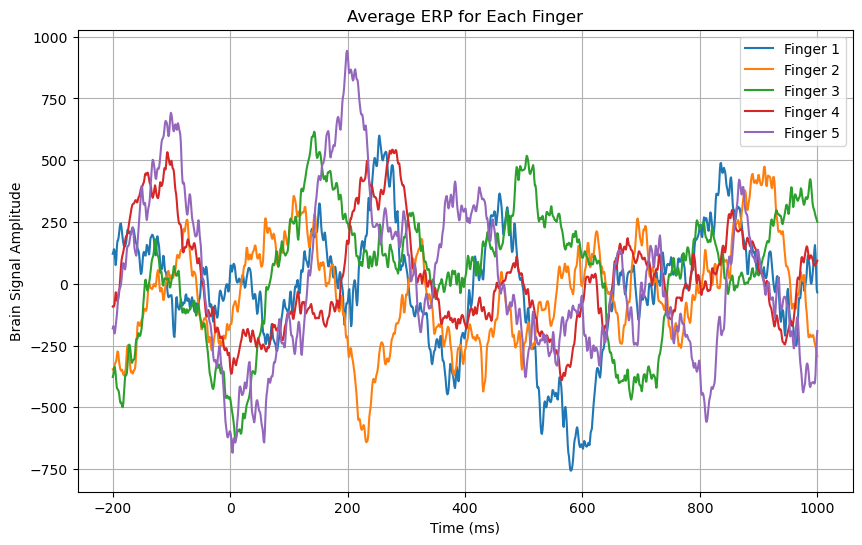

Skipped trials due to out-of-bounds indices: 0
The first 5 rows of the 5x1201 matrix:
          0           1           2           3           4           5     \
0  121.585938  128.078125  140.179688  135.187500  101.851562   75.820312   
1 -346.252101 -345.361345 -342.798319 -333.630252 -323.084034 -317.974790   
2 -377.333333 -367.991667 -346.641667 -336.325000 -344.958333 -365.325000   
3  -92.447368  -89.542105  -91.615789  -84.073684  -58.947368  -34.610526   
4 -180.351351 -171.594595 -185.486486 -201.135135 -192.472973 -170.932432   

         6           7           8           9     ...        1191  \
0   97.250000  147.015625  173.390625  176.007812  ...   14.507812   
1 -311.294118 -293.008403 -273.924370 -275.781513  ... -213.831933   
2 -396.366667 -421.033333 -426.291667 -428.466667  ...  348.725000   
3  -37.057895  -58.847368  -71.147368  -65.352632  ...  106.505263   
4 -151.108108 -126.689189  -96.783784  -61.797297  ... -399.918919   

         1192        1193    

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calc_mean_erp(trial_points, ecog_data):
    """
    Calculate and plot the mean ERP for each finger movement.
    
    Args:
    trial_points (DataFrame): DataFrame with columns containing the starting point, peak point, and finger number.
    ecog_data (DataFrame): DataFrame with one column representing the time-series brain signal.
    
    Returns:
    np.ndarray: A 5x1201 matrix where each row corresponds to a finger's average ERP.
    """
    # Validate inputs
    if trial_points.empty or ecog_data.empty:
        raise ValueError("Input DataFrames cannot be empty.")
    
    # Print column names for debugging
    print("Columns in trial_points:", trial_points.columns)
    
    # Ensure trial_points has the correct column names
    expected_cols = ['start', 'peak', 'finger']
    if not all(col in trial_points.columns for col in expected_cols):
        raise ValueError(f"`trial_points` must contain columns: {expected_cols}. Found: {trial_points.columns.tolist()}")
    
    # Assign proper column names and ensure integer types
    trial_points.columns = expected_cols
    trial_points = trial_points.astype({'start': int, 'peak': int, 'finger': int})

    # Define constants
    pre_event_duration = 200  # ms before the start of movement
    post_event_duration = 1000  # ms after the start of movement
    total_samples = pre_event_duration + post_event_duration + 1  # 1201 samples

    # Initialize matrix for averaged ERPs (5 fingers, 1201 time points)
    fingers_erp_mean = np.zeros((5, total_samples))
    skipped_trials = 0  # Counter for skipped trials

    for finger_id in range(1, 6):  # Loop through each finger
        # Filter trials for the current finger
        finger_trials = trial_points[trial_points['finger'] == finger_id]

        # Collect all brain signal segments for the current finger
        finger_signals = []
        for _, row in finger_trials.iterrows():
            start_index = int(row['start']) - pre_event_duration
            end_index = int(row['start']) + post_event_duration + 1
            
            # Extract the segment if within bounds
            if 0 <= start_index < len(ecog_data) and 0 <= end_index <= len(ecog_data):
                signal_segment = ecog_data.iloc[start_index:end_index].values.flatten()
                finger_signals.append(signal_segment)
            else:
                skipped_trials += 1  # Count skipped trials
        
        # Compute the average ERP for this finger if signals exist
        if finger_signals:
            fingers_erp_mean[finger_id - 1, :] = np.mean(finger_signals, axis=0)

    # Plot the ERPs
    time_axis = np.linspace(-200, 1000, total_samples)  # Time axis in ms
    plt.figure(figsize=(10, 6))
    for finger_id in range(1, 6):
        plt.plot(time_axis, fingers_erp_mean[finger_id - 1, :], label=f'Finger {finger_id}')
    plt.title('Average ERP for Each Finger')
    plt.xlabel('Time (ms)')
    plt.ylabel('Brain Signal Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    # Log skipped trials
    print(f"Skipped trials due to out-of-bounds indices: {skipped_trials}")

    return fingers_erp_mean

# Load the CSV files and adjust column names if needed
trial_points = pd.read_csv('C:\\Users\\97253\\OneDrive\\שולחן העבודה\\jupyter notebook\\events_file_ordered.csv')
ecog_data = pd.read_csv('C:\\Users\\97253\\OneDrive\\שולחן העבודה\\jupyter notebook\\brain_data_channel_one.csv', header=None, names=["ECOG_Signal"])

# Print trial_points columns for debugging
print("Loaded trial_points columns:", trial_points.columns)

# Adjust column names if they are not standard
if set(['start', 'peak', 'finger']) != set(trial_points.columns):
    trial_points.rename(columns={
        trial_points.columns[0]: 'start',
        trial_points.columns[1]: 'peak',
        trial_points.columns[2]: 'finger'
    }, inplace=True)

# Call the function
fingers_erp_mean = calc_mean_erp(trial_points, ecog_data)

# Display the first few rows of the fingers_erp_mean matrix
print("The first 5 rows of the 5x1201 matrix:\n", pd.DataFrame(fingers_erp_mean).head())

# Save the results to a CSV file for further inspection
fingers_erp_mean_df = pd.DataFrame(fingers_erp_mean)
fingers_erp_mean_df.to_csv('fingers_erp_mean_output.csv', index=False)
print("\nResults saved to 'fingers_erp_mean_output.csv'")
